# LPIPS: Perceptual Similarity for Ultrasound Images

Assessment of ultrasound image quality is one of the more notorious challenges. zea offers a variety of commonly used metrics in `zea.metrics`. In this notebook, we demonstrate how to use the [LPIPS](https://github.com/richzhang/PerceptualSimilarity) model to compute perceptual similarity between ultrasound images using the `zea` toolbox. Besides common distortion metrics, a perceptual metric can be a good complementary metric to assess image quality. For more info, see an interesting paper called: [The Perception-Distortion Tradeoff](https://arxiv.org/abs/1711.06077). First we'll set an appropriate backend for Keras.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tue-bmd/zea/blob/main/docs/source/notebooks/metrics/lpips_example.ipynb)
&nbsp;
[![View on GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tue-bmd/zea/blob/main/docs/source/notebooks/lpips/lpips_example.ipynb)
&nbsp;
[![Hugging Face model](https://img.shields.io/badge/Hugging%20Face-Model-yellow?logo=huggingface)](https://huggingface.co/zeahub/lpips)

In [ ]:
%%capture
%pip install zea

In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from keras import ops

from zea import init_device
from zea.backend.tensorflow.dataloader import make_dataloader
from zea.models.lpips import LPIPS
from zea.visualize import plot_image_grid, set_mpl_style

zea: Using backend 'jax'


We will work with the GPU if available, and initialize using `init_device` to pick the best available device. Also, (optionally), we will set the matplotlib style for plotting.

In [3]:
init_device(verbose=False)
set_mpl_style()

## Load data
We load a small batch from the CAMUS validation dataset hosted on Hugging Face Hub.

In [4]:
n_imgs = 9
val_dataset = make_dataloader(
    "hf://zeahub/camus-sample/val",
    key="data/image",
    batch_size=n_imgs,
    shuffle=True,
    image_size=[256, 256],
    resize_type="resize",
    image_range=[-60, 0],
    normalization_range=[-1, 1],
    seed=42,
)

zea: Using pregenerated dataset info file: /home/devcontainer15/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/dataset_info.yaml ...
zea: ...for reading file paths in /home/devcontainer15/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val
zea: Dataset was validated on June 13, 2025
zea: Remove /home/devcontainer15/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/validated.flag if you want to redo validation.
zea: WARNING H5Generator: Not all files have the same shape. This can lead to issues when resizing images later....
zea: H5Generator: Shuffled data.


## Load LPIPS Model

We use the built-in LPIPS model from `zea`.

In [5]:
model = LPIPS.from_preset("lpips")

We select one image as the reference and the rest as example images. LPIPS expects RGB images, so we tile the grayscale images to 3 channels.

In [6]:
batch = next(iter(val_dataset))

reference_image = batch[0]
example_images = batch[1:]

zea: H5Generator: Shuffled data.


## Compute LPIPS Similarity

We compute the LPIPS similarity between the reference image and each example image.

In [7]:
lpips_scores = []
for example_image in example_images:
    score = model((reference_image, example_image))
    lpips_scores.append(score)
lpips_scores = ops.concatenate(lpips_scores, axis=0)
lpips_scores = ops.convert_to_numpy(lpips_scores)

## Visualization

We plot the images, highlight the reference (red border) and the most similar image (green border), and display the LPIPS scores.

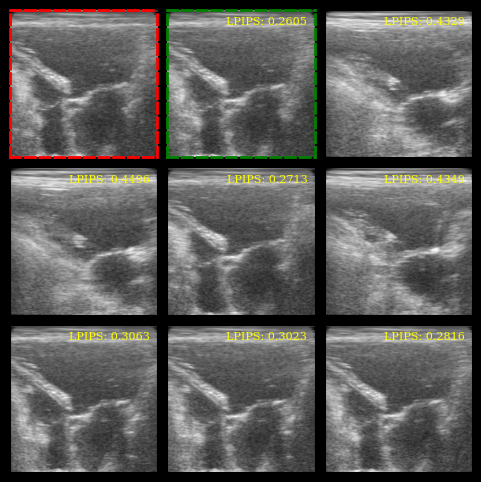

In [8]:
batch_np = ops.convert_to_numpy(batch)
batch_np = ((batch_np + 1) / 2 * 255).astype(np.uint8)

fig, _ = plot_image_grid(batch_np, remove_axis=False)
axes = fig.axes[:n_imgs]

# Red border for reference image
for spine in axes[0].spines.values():
    spine.set_edgecolor("red")
    spine.set_linewidth(2)
    spine.set_linestyle("--")

# Green border for most similar image
most_similar_idx = lpips_scores.argmin()
for spine in axes[most_similar_idx + 1].spines.values():
    spine.set_edgecolor("green")
    spine.set_linewidth(2)
    spine.set_linestyle("--")

# LPIPS scores as text
for ax, lpips_score in zip(axes[1:], lpips_scores):
    ax.text(
        0.95,
        0.95,
        f"LPIPS: {float(lpips_score):.4f}",
        ha="right",
        va="top",
        transform=ax.transAxes,
        fontsize=8,
        color="yellow",
    )
plt.show()